In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from utils.functions import *
import json
from utils.graph_repair import repair_network
import matplotlib.patches as patches

Please install pyparsing, pydot & graphviz if you want to draw graphs or lattice diagrams


In [29]:
input_file = 'PNAS_8worm_dataset_v2.mat'
cmap = get_colormap()

worm_dicts = read_input_mat_file(input_file, style = 1, remove_trend=True, smooth_spikes=True, mean_zero=True)
# worm_dicts = read_input_mat_file(input_file, style = 1, remove_trend=False, smooth_spikes=False, mean_zero=False)

# worm_dicts = read_input_mat_file('pedro_files.mat', style = 2, remove_trend=False, smooth_spikes=False, mean_zero=False)
# annots = [x['annot'] for x in read_input_mat_file(input_file, style = 1, remove_trend=False, smooth_spikes=False, mean_zero=False)]
# for idx in range(len(worm_dicts)):
#     worm_dicts[idx]['annot'] = annots[idx]
    
averaged_results = calculate_metrics(worm_dicts, use_annotations = True, return_average = True)

100%|██████████| 8/8 [00:39<00:00,  4.93s/it]


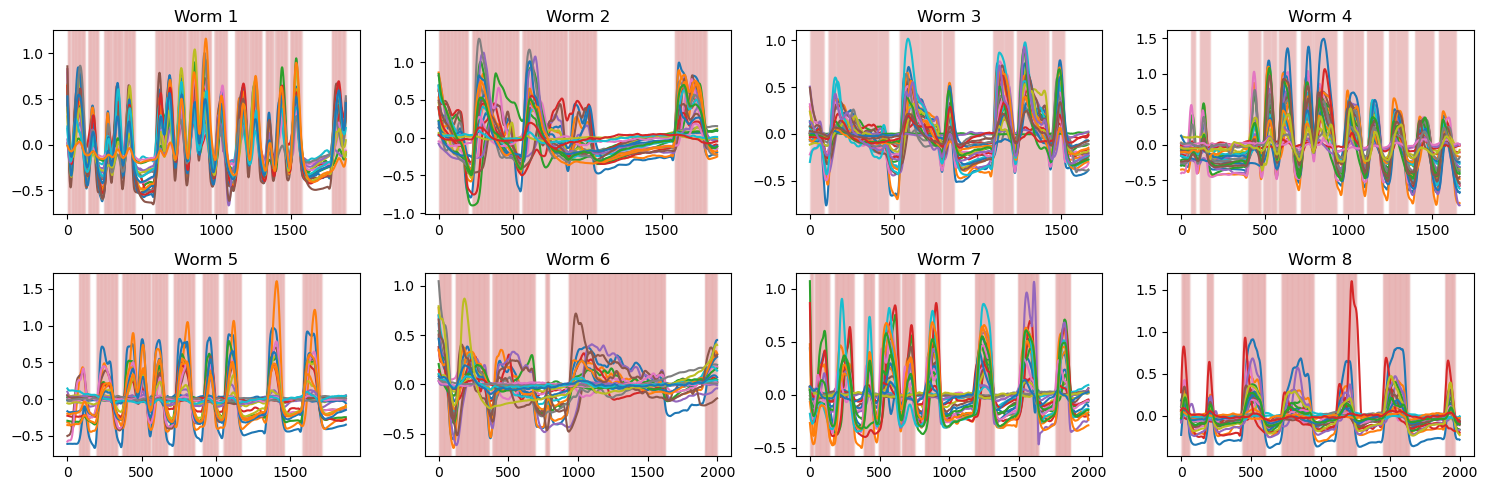

In [30]:
fig, ax = plt.subplots(2, 4, figsize=(15, 5))
ax = ax.flatten()

for i, worm_dict in enumerate(worm_dicts):
    for key, value in worm_dict.items():
        if key == 'annot':
            for idx in range(len(value)):
                if value[idx] > 1:
                    ax[i].axvspan(idx, idx, color='tab:red', alpha=0.03)
        else:
            ax[i].plot(value)
    ax[i].set_title(f'Worm {i+1}')
    
plt.tight_layout()

In [31]:
pairs = list(set(averaged_results.keys()))

## all neurons including AVAR, AVAL, etc
# all_neurons = list(set([item for sublist in pairs for item in sublist]))
# all_neurons.sort()

## to replicate the results in the paper
# all_neurons = ['VA05', 'VA06', 'VA07', 'DA07', 'DA08', 'VA04', 'DA09', 'DA02', 'VA02', 'DA03', 'VA01', 'DA01', 'DA06', 'DA04', 'VA08', 'DA05', 'VA11', 'VA09', 'VA10', 'VA03', 'VA12']
all_neurons = ['DA02', 'VA02', 'VA03', 'DA03', 'DA01', 'DA08', 'DA09', 'VA12', 'VA07', 'VA05', 'VA04', 'VA06', 'DA07', 'VA01', 'VA09', 'VA10', 'VA11', 'DA05', 'DA04', 'VA08', 'DA06']
# all_neurons = ['VA04', 'VA05', 'VA06', 'VA02', 'DA08', 'VA07', 'DA02', 'DA09', 'VA03', 'VA11', 'VA12', 'VA08', 'VA09', 'VA10', 'DA03', 'DA04', 'DA07', 'DA01', 'DA05', 'VA01', 'DA06']

mapping_neuron_to_idx = {all_neurons[idx]:idx for idx in range(len(all_neurons))}
mapping_idx_to_neuron = {idx:all_neurons[idx] for idx in range(len(all_neurons))}

In [32]:
matrices = {}
modified_matrices = {}

for metric in averaged_results[pairs[0]]:
    matrix = np.ones((len(mapping_neuron_to_idx), len(mapping_neuron_to_idx)))
    for pair in pairs:
        if pair[0] in mapping_neuron_to_idx and pair[1] in mapping_neuron_to_idx:
            matrix[mapping_neuron_to_idx[pair[0]], mapping_neuron_to_idx[pair[1]]] = averaged_results[pair][metric]
            matrix[mapping_neuron_to_idx[pair[1]], mapping_neuron_to_idx[pair[0]]] = averaged_results[pair][metric]
    
    threshold = calculate_percolation(matrix)
    modified_matrix = np.where(matrix >= threshold, matrix, 0)
    
    matrices[metric] = matrix
    modified_matrices[metric] = modified_matrix

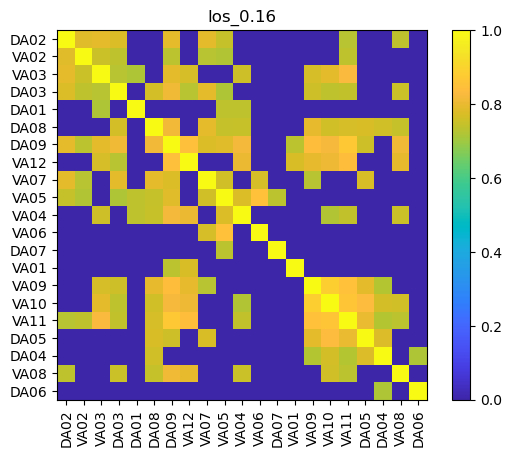

In [34]:
metric = 'los_0.16'
# metric = 'pearson'
plt.imshow(modified_matrices[metric], cmap=cmap, vmin=0, vmax=1)
plt.xticks(range(len(all_neurons)), all_neurons, rotation=90)
plt.yticks(range(len(all_neurons)), all_neurons)
plt.title(metric)
plt.colorbar();

In [35]:
datatable = [['louvain', 'covariance', 'cov'], ['louvain', 'los_0.060000000000000005', 'los_06'],
             ['clique', 'covariance', 'cov'], ['clique', 'los_0.16', 'los_16'], ['clique', 'los_0.17', 'los_17']]

for method, metric, name in tqdm(datatable):
    all_cliques = []

    if method == 'louvain':
        louvain_results = louvain_clustering_best_modularity(modified_matrices[metric], all_neurons, 1000)
        clusters = louvain_results
    if method == 'clique':
        valid_cliques = check_cliques_struc_v2(modified_matrices[metric], all_neurons, 2, 9)
        refined_cliques = refine_cliques(valid_cliques)
        clusters = refined_cliques

    with open(f'colorings/{method[:4]}_{name}_colors.txt', 'w') as f:
        for idx, clique in enumerate(clusters):
            for node in clique:
                print(f'{node}\t{idx}', file=f)
            
        print(f'AVEL\t{idx+1}', file=f)
        print(f'AVER\t{idx+1}', file=f)
        
        print(f'AVDL\t{idx+2}', file=f)
        print(f'AVDR\t{idx+2}', file=f)
        
        print(f'AVAL\t{idx+3}', file=f)
        print(f'AVAR\t{idx+3}', file=f)

100%|██████████| 5/5 [05:14<00:00, 62.87s/it]


In [36]:
df_weights = pd.read_csv('connectomes/collapsed_varshney_weights.txt', sep='\t', header=None)

In [39]:
res = {}

for run in datatable:
    res[run[0]+ '-' + run[2]] = {}
    for a in [1,2]:
        for b in [1,2]:
            EdgesRemoved,EdgesAdded, G_result = repair_network(f"colorings/{run[0][:4]}_{run[2]}_colors.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_{run[0][:4]}_{run[2]}_colors_o_", a, b)
            # res[run[0]+ '-' + run[2]][(a,b)] = [(len(EdgesRemoved)+len(EdgesAdded))/56.0]
            res[run[0]+ '-' + run[2]][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights[2].sum()
            # res[run[0]+ '-' + run[2]][(a,b)] = (sum([df_weights[(df_weights[0] == edge[0]) & (df_weights[1] == edge[1])][2].values[0] for edge in EdgesRemoved]) + len(EdgesAdded)) / df_weights.shape[0]

#######TIME TO SET UP#######

Reading data from connectomes/collapsed_varshney.graph.txt and colorings/louv_cov_colors.txt
Read graph: n=23 m=57
Read colors
Created tuples
created all pairs
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2598042
Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Creating model
0.2768847942352295
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.2.0 24C101)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.1

Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Optimize a model with 6246 rows, 4983 columns and 48360 nonzeros
Model fingerprint: 0xf20d8ac6
Model has 284 simple general constraints
  284 ABS
Variable types: 135 continuous, 4280 integer (4280 binary)
Semi-Variable types: 0 continuou

In [40]:
res

{'louvain-cov': {(1, 1): 0.13714285714285715,
  (1, 2): 0.13714285714285715,
  (2, 1): 0.13714285714285715,
  (2, 2): 0.13714285714285715},
 'louvain-los_06': {(1, 1): 0.14285714285714285,
  (1, 2): 0.14285714285714285,
  (2, 1): 0.15428571428571428,
  (2, 2): 0.14285714285714285},
 'clique-cov': {(1, 1): 0.10285714285714286,
  (1, 2): 0.12,
  (2, 1): 0.10857142857142857,
  (2, 2): 0.10285714285714286},
 'clique-los_16': {(1, 1): 0.17714285714285713,
  (1, 2): 0.16,
  (2, 1): 0.13714285714285715,
  (2, 2): 0.16},
 'clique-los_17': {(1, 1): 0.17714285714285713,
  (1, 2): 0.16,
  (2, 1): 0.13714285714285715,
  (2, 2): 0.16}}

In [ ]:
# plot_graph_with_weights_and_groups(modified_matrices['los_0.16'], all_neurons, louvain_results)

In [15]:
try:
    with open('precomputed/all_cliques_detrend_demean_despike.json', 'r') as file:
        # Load the JSON data from the file
        all_cliques = json.load(file)
except:
    all_cliques = []

    for metric, matrix in tqdm(modified_matrices.items(), total=len(modified_matrices)):
        valid_cliques = check_cliques_struc_v2(matrix, all_neurons, 2, 9)
        refined_cliques = refine_cliques(valid_cliques)
        louvain_results = louvain_clustering_best_modularity(matrix, all_neurons, 100)
        
        all_cliques.append(refined_cliques)
        all_cliques.append(louvain_results)
        
    # Convert the list to a JSON string
    json_string = json.dumps(all_cliques)

    # Save the JSON string to a file
    with open("precomputed/all_cliques_detrend_demean_despike.json", "w") as f:
        f.write(json_string)

In [16]:
def create_point_cluster_mapping(clustering_results, columns):
    points = set()
    metric_cluster_mapping = []

    # Collect unique points and map their clusters
    for metric in clustering_results:
        metric_map = {}
        for cluster_id, cluster_points in enumerate(metric):
            for point in cluster_points:
                metric_map[point] = cluster_id
                points.add(point)
        metric_cluster_mapping.append(metric_map)

    # Convert to DataFrame
    points = sorted(points)  # Ensure consistent ordering
    data = []
    for metric_map in metric_cluster_mapping:
        data.append([metric_map.get(point, -1) for point in points])  # -1 if point is not in metric

    return pd.DataFrame(data, index=columns, columns=points).T

In [19]:
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, jaccard_score

metric_names = [[x[:10]+'_c', x[:10]+'_l'] for x in list(modified_matrices.keys())]
metric_names = sum(metric_names, [])

df = create_point_cluster_mapping(all_cliques, metric_names)
res = np.zeros((len(df.columns), len(df.columns)))

for col1 in enumerate(df.columns):
    for col2 in enumerate(df.columns):
        # res[col1[0], col2[0]] = adjusted_rand_score(df[col1[1]], df[col2[1]])
        res[col1[0], col2[0]] = normalized_mutual_info_score(df[col1[1]], df[col2[1]])
        # res_clique[col1[0], col2[0]] = normalized_mutual_info_score(df_clusters_cliq[col1[1]], df_clusters_cliq[col2[1]]
        # res[col1[0], col2[0]] = jaccard_score(df[col1[1]], df[col2[1]], average='macro')

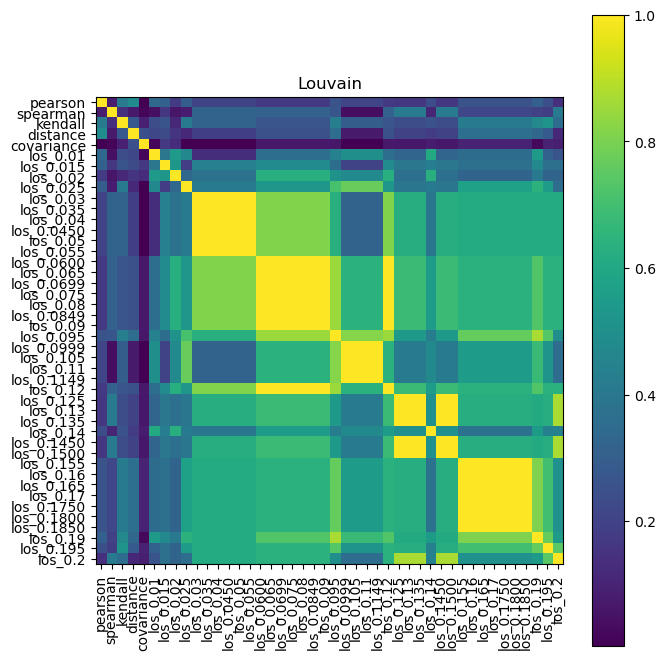

In [36]:
plt.figure(figsize=(7, 7))
# plt.imshow(res[::2, ::2], cmap='viridis')
# plt.title('Clique')
plt.imshow(res[1::2, 1::2], cmap='viridis')
plt.title('Louvain')

plt.xticks(range(44), [x[:-2] for x in metric_names[1::2]], rotation=90)
plt.yticks(range(44), [x[:-2] for x in metric_names[1::2]])
plt.colorbar()

plt.tight_layout()

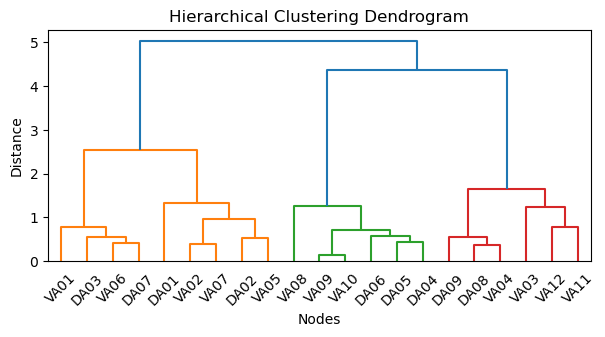

In [42]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

cooccurrence_matrix = get_cooccurrence_matrix(all_cliques, mapping_neuron_to_idx)

# Step 4: Perform Hierarchical Clustering using Ward's Method
linkage_matrix = linkage(cooccurrence_matrix, method='ward')

# Step 5: Plot the Dendrogram
plt.figure(figsize=(7, 3))
dendo = dendrogram(linkage_matrix, labels=all_neurons)
cooccurrence_matrix = cooccurrence_matrix[np.ix_(dendo['leaves'], dendo['leaves'])]
new_node_order = [all_neurons[node] for node in dendo['leaves']]
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Nodes")
plt.ylabel("Distance")
plt.show()

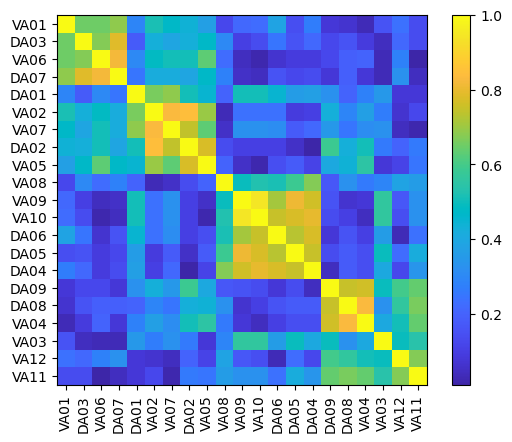

In [43]:
plt.imshow(cooccurrence_matrix, cmap=cmap)
plt.xticks(range(len(new_node_order)), new_node_order, rotation=90)
plt.yticks(range(len(new_node_order)), new_node_order)
plt.colorbar()


squares = [
    [0, 6, 2.5],
    [7, 10, 2.5],
    [11, 20, 2.5],
    [0, 2, 1.3],
    [3, 6, 1.3],
    [11, 15, 1.3],
    [16, 20, 1.3],
]
# for start, end, thickness in squares:
#     # Add a square (rectangle with equal height and width)
#     ax = plt.gca()
#     rect = patches.Rectangle(
#         (start - 0.5, start - 0.5),  # Rectangle starts slightly offset to align with pixels
#         end - start + 1,            # Width
#         end - start + 1,            # Height
#         linewidth=thickness,                    # Line thickness
#         edgecolor='black',                # Line color
#         facecolor='none'                # Transparent fill
#     )
#     ax.add_patch(rect)

In [27]:
for n_cluster in [3,4,5,6,7,8,9,10]:
    clusters = fcluster(linkage_matrix, n_cluster, criterion='maxclust')

    with open(f'colorings/cons_{n_cluster}_colors.txt', 'w') as f:
        max_id = np.max(clusters)
        for idx, neuron in enumerate(all_neurons):
            print(f'{neuron}\t{clusters[idx]}', file=f)
            
        print(f'AVEL\t{max_id+1}', file=f)
        print(f'AVER\t{max_id+1}', file=f)
        
        print(f'AVDL\t{max_id+2}', file=f)
        print(f'AVDR\t{max_id+2}', file=f)
        
        print(f'AVAL\t{max_id+3}', file=f)
        print(f'AVAR\t{max_id+3}', file=f)

In [28]:
res = {}

for idx, i in enumerate([3,4,5,6,7,8,9,10]):
    res[i] = {}
    for a in [1,2,3]:
        for b in [1,2,3]:
            EdgesRemoved,EdgesAdded, G_result = repair_network(f"colorings/cons_{i}_colors.txt", "connectomes/collapsed_varshney.graph.txt", f"outputs/collapsed_cons_{i}_colors_o_", a, b)
            res[i][(a,b)] = [(len(EdgesRemoved)+len(EdgesAdded))/56.0]

#######TIME TO SET UP#######

Reading data from connectomes/collapsed_varshney.graph.txt and colorings/cons_3_colors.txt
Read graph: n=23 m=56
Read colors
Created tuples
created all pairs
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2598042
Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Creating model
0.2782747745513916
Set parameter MIPGap to value 0.1
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 24.1.0 24B91)

CPU model: Apple M1
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Non-default parameters:
MIPGap  0.1

Academic license 2598042 - for non-commercial use only - registered to ah___@gradcenter.cuny.edu
Optimize a model with 6222 rows, 4959 columns and 48164 nonzeros
Model fingerprint: 0xef766f7b
Model has 282 simple general constraints
  282 ABS
Variable types: 139 continuous, 4256 integer (4256 binary)
Semi-Variable types: 0 continuous, 

In [43]:
res[7]

{(1, 1): [0.35714285714285715],
 (1, 2): [0.35714285714285715],
 (1, 3): [0.35714285714285715],
 (2, 1): [0.35714285714285715],
 (2, 2): [0.35714285714285715],
 (2, 3): [0.35714285714285715],
 (3, 1): [0.375],
 (3, 2): [0.35714285714285715],
 (3, 3): [0.35714285714285715]}